In [1]:
import os

target_dir = "/kaggle/input/ua-detrac-dataset/content/UA-DETRAC/DETRAC_Upload/labels"

# List only label files
label_files = os.listdir(target_dir)
print("Sample label files:", label_files[:5])


Sample label files: ['val', 'train']


In [2]:
train_label_dir = os.path.join(target_dir, "train")
train_files = os.listdir(train_label_dir)
print("Sample training annotation files:", train_files[:5])


Sample training annotation files: ['MVI_39771_img00454.txt', 'MVI_20062_img00518.txt', 'MVI_63563_img00261.txt', 'MVI_63554_img01000.txt', 'MVI_40981_img01780.txt']


In [3]:
def parse_yolo_label_file(file_path):
    labels = []
    with open(file_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            if len(parts) == 5:
                class_id, x_center, y_center, width, height = map(float, parts)
                labels.append({
                    "class_id": int(class_id),
                    "x_center": x_center,
                    "y_center": y_center,
                    "width": width,
                    "height": height
                })
    return labels


In [4]:
import os

sample_label_file = os.path.join(train_label_dir, "MVI_39771_img00454.txt")
annotations = parse_yolo_label_file(sample_label_file)
annotations[:3]


[{'class_id': 3,
  'x_center': 0.62263,
  'y_center': 0.23638,
  'width': 0.04126,
  'height': 0.067426},
 {'class_id': 1,
  'x_center': 0.439411,
  'y_center': 0.367148,
  'width': 0.037927,
  'height': 0.064259},
 {'class_id': 1,
  'x_center': 0.426854,
  'y_center': 0.302556,
  'width': 0.027479,
  'height': 0.042556}]

In [5]:
import os

image_base_dir = "/kaggle/input/ua-detrac-dataset/content/UA-DETRAC/DETRAC_Upload/images/train"
sample_images = os.listdir(image_base_dir)
print("Sample image files:", sample_images[:5])


Sample image files: ['MVI_40992_img00471.jpg', 'MVI_39851_img00150.jpg', 'MVI_39801_img00362.jpg', 'MVI_40181_img01264.jpg', 'MVI_63562_img00401.jpg']


In [6]:
import cv2
import matplotlib.pyplot as plt

def show_yolo_bbox(image_path, label_path):
    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for plotting
    height, width, _ = image.shape

    # Parse labels
    boxes = parse_yolo_label_file(label_path)

    for box in boxes:
        x_center = int(box["x_center"] * width)
        y_center = int(box["y_center"] * height)
        w = int(box["width"] * width)
        h = int(box["height"] * height)

        x1 = int(x_center - w / 2)
        y1 = int(y_center - h / 2)
        x2 = int(x_center + w / 2)
        y2 = int(y_center + h / 2)

        # Draw rectangle
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, f'Class {box["class_id"]}', (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

    # Show image
    plt.figure(figsize=(10, 6))
    plt.imshow(image)
    plt.axis("off")
    plt.show()


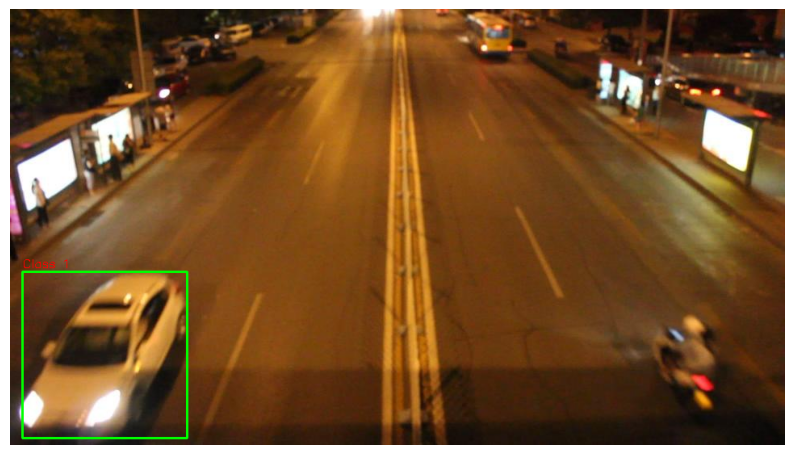

In [7]:
sample_image_file = "MVI_39851_img00150.jpg"
image_path = os.path.join(image_base_dir, sample_image_file)
label_path = os.path.join(train_label_dir, sample_image_file.replace(".jpg", ".txt"))

show_yolo_bbox(image_path, label_path)


In [8]:
#visualizing annotation quality 
import seaborn as sns

def analyze_box_sizes(label_dir, sample_size=500):
    widths, heights = [], []
    count = 0

    for file in os.listdir(label_dir):
        if file.endswith('.txt'):
            boxes = parse_yolo_label_file(os.path.join(label_dir, file))
            for box in boxes:
                widths.append(box['width'])
                heights.append(box['height'])
            count += 1
            if count >= sample_size:
                break

    # Plot
    plt.figure(figsize=(12, 6))
    sns.histplot(widths, bins=30, color='skyblue', label='Width', kde=True)
    sns.histplot(heights, bins=30, color='orange', label='Height', kde=True)
    plt.title('Distribution of Normalized Box Sizes')
    plt.legend()
    plt.xlabel('Size (normalized 0 to 1)')
    plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


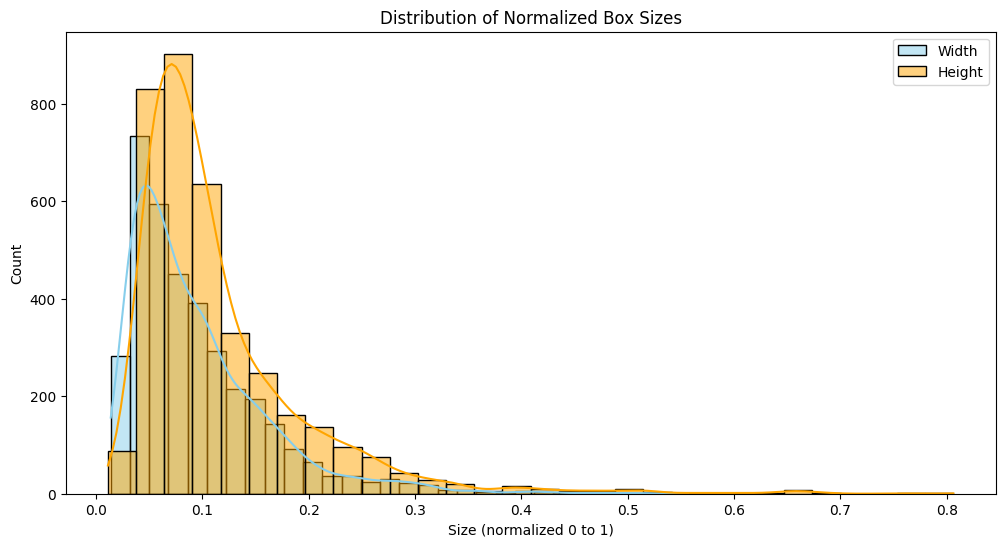

In [9]:
analyze_box_sizes(train_label_dir)


In [10]:
def check_missing_labels(label_dir, image_dir):
    missing = []
    for img in os.listdir(image_dir):
        label_file = img.replace('.jpg', '.txt')
        label_path = os.path.join(label_dir, label_file)
        if not os.path.exists(label_path):
            missing.append(img)
        elif os.path.getsize(label_path) == 0:
            missing.append(img)
    print(f"Total images with missing/empty labels: {len(missing)}")
    print("Examples:", missing[:5])


In [11]:
check_missing_labels(train_label_dir, image_base_dir)


Total images with missing/empty labels: 1706
Examples: ['MVI_39851_img00282.jpg', 'MVI_63544_img00949.jpg', 'MVI_39761_img00956.jpg', 'MVI_63544_img01061.jpg', 'MVI_39761_img00910.jpg']


In [12]:
#most file here are not annotated . to check the empty files it goes as 

In [13]:
import os

label_dir = "/kaggle/input/ua-detrac-dataset/content/UA-DETRAC/DETRAC_Upload/labels"

empty_labels = []
non_empty_labels = []

for label_file in os.listdir(label_dir):
    path = os.path.join(label_dir, label_file)
    # Skip directories
    if os.path.isdir(path):
        continue

    with open(path, 'r') as f:
        content = f.read().strip()
        if content == "":
            empty_labels.append(label_file)
        else:
            non_empty_labels.append(label_file)

print(f"Total empty labels: {len(empty_labels)}")
print(f"Examples of empty label files: {empty_labels[:5]}")

# Save empty label filenames for annotation team
with open("empty_labels.txt", "w") as f:
    for file in empty_labels:
        f.write(file + "\n")

# Save non-empty label filenames (to be used for training)
with open("non_empty_labels.txt", "w") as f:
    for file in non_empty_labels:
        f.write(file + "\n")


Total empty labels: 0
Examples of empty label files: []


In [14]:
#visulaizing annotations on images 

import cv2
import matplotlib.pyplot as plt
import os

# Define your class names based on UA-DETRAC dataset documentation (example)
class_names = {
    0: 'car',
    1: 'van',
    2: 'bus',
    3: 'truck',
    4: 'motorcycle',
    5: 'bicycle',
    6: 'pedestrian'
}

def yolo_to_bbox(x_center, y_center, width, height, img_width, img_height):
    # Convert normalized YOLO bbox to pixel bbox (xmin, ymin, xmax, ymax)
    xmin = int((x_center - width / 2) * img_width)
    ymin = int((y_center - height / 2) * img_height)
    xmax = int((x_center + width / 2) * img_width)
    ymax = int((y_center + height / 2) * img_height)
    return xmin, ymin, xmax, ymax


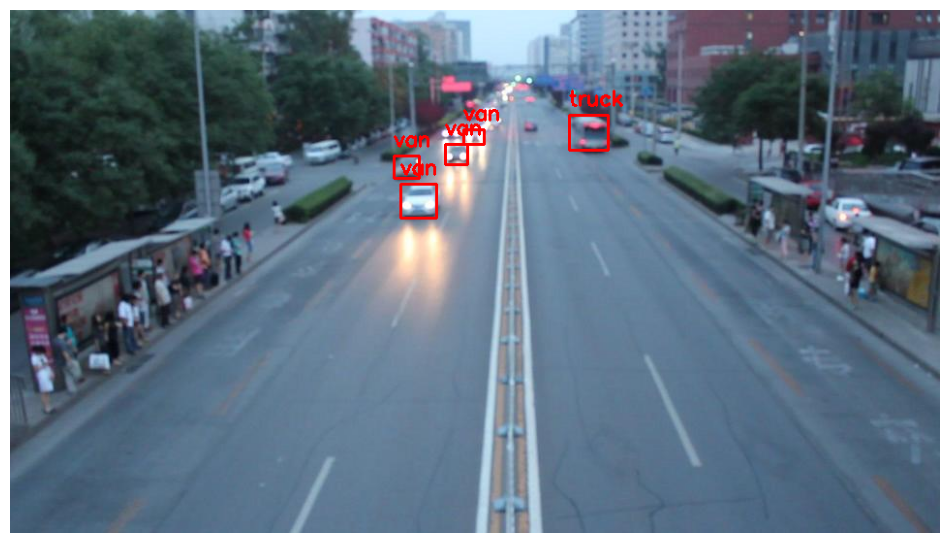

In [15]:
# Set paths - update according to your directory structure
image_dir = "/kaggle/input/ua-detrac-dataset/content/UA-DETRAC/DETRAC_Upload/images/train"
label_dir = "/kaggle/input/ua-detrac-dataset/content/UA-DETRAC/DETRAC_Upload/labels/train"

# Pick a sample label file
sample_label_file = "MVI_39771_img00454.txt"  # Change as needed
label_path = os.path.join(label_dir, sample_label_file)

# Image file name (replace .txt with .jpg)
image_file = sample_label_file.replace(".txt", ".jpg")
image_path = os.path.join(image_dir, image_file)

# Load image
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib

# Get image dimensions
img_height, img_width, _ = img.shape

# Read annotations
with open(label_path, 'r') as f:
    lines = f.readlines()

# Draw bounding boxes
for line in lines:
    class_id, x_center, y_center, width, height = line.strip().split()
    class_id = int(class_id)
    x_center, y_center, width, height = map(float, [x_center, y_center, width, height])

    xmin, ymin, xmax, ymax = yolo_to_bbox(x_center, y_center, width, height, img_width, img_height)
    
    # Draw rectangle and label on image
    color = (255, 0, 0)  # Red box; you can randomize colors if you want
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), color, 2)
    cv2.putText(img, class_names[class_id], (xmin, ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

# Show image with annotations
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis('off')
plt.show()


In [16]:
#validating annotation quality

In [1]:
#annotation editor




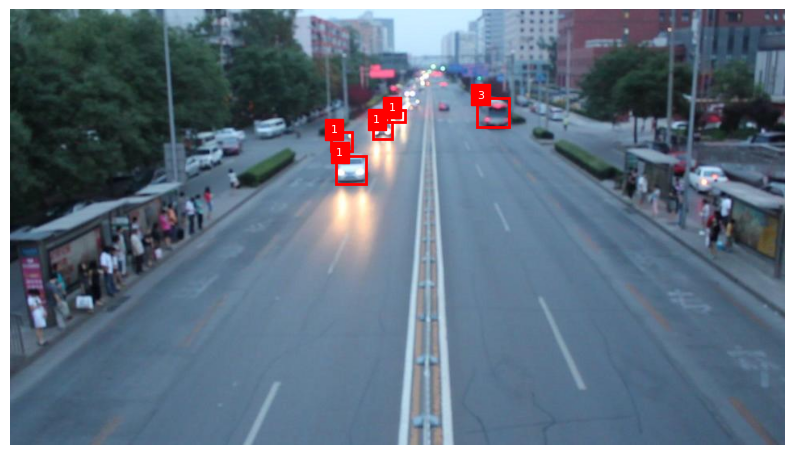

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import os

def display_image_with_boxes(img_path, label_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_h, img_w = img.shape[:2]

    fig, ax = plt.subplots(1, figsize=(10, 8))
    ax.imshow(img)

    with open(label_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            parts = line.strip().split()
            cls, x, y, w, h = parts
            x, y, w, h = float(x), float(y), float(w), float(h)
            # Convert YOLO to corner box
            xmin = (x - w / 2) * img_w
            ymin = (y - h / 2) * img_h
            rect = patches.Rectangle((xmin, ymin), w * img_w, h * img_h, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(xmin, ymin, cls, color='white', fontsize=8, backgroundcolor='red')

    plt.axis('off')
    plt.show()

# Example usage
img_path = '/kaggle/input/ua-detrac-dataset/content/UA-DETRAC/DETRAC_Upload/images/train/MVI_39771_img00454.jpg'
label_path = img_path.replace('images', 'labels').replace('.jpg', '.txt')
display_image_with_boxes(img_path, label_path)


In [4]:
#creating project folders
import os
import shutil

# Create main output folder
output_dir = "/kaggle/working/detrac_annotation_validation"
os.makedirs(output_dir, exist_ok=True)

# Create subfolders for filtered labels and visualizations
filtered_label_dir = os.path.join(output_dir, "filtered_labels")
os.makedirs(filtered_label_dir, exist_ok=True)

viz_dir = os.path.join(output_dir, "visualizations")
os.makedirs(viz_dir, exist_ok=True)

print("Project folders created.")


Project folders created.


In [5]:
#copying clean label files
import os
import shutil

label_base_dir = "/kaggle/input/ua-detrac-dataset/content/UA-DETRAC/DETRAC_Upload/labels/train"

for label_file in os.listdir(label_base_dir):
    full_path = os.path.join(label_base_dir, label_file)
    
    if os.path.isfile(full_path):
        with open(full_path, 'r') as f:
            content = f.read().strip()
            if content:  # If not empty
                shutil.copy(full_path, filtered_label_dir)

print(f"Copied non-empty label files to: {filtered_label_dir}")


Copied non-empty label files to: /kaggle/working/detrac_annotation_validation/filtered_labels


In [6]:
#a README summary 

summary_path = os.path.join(output_dir, "README.txt")

summary = """
UA-DETRAC Annotation Validation Project

 Project Goal:
Validate and clean bounding box annotations for object detection.

 Processed:
- Removed empty/missing label files (total removed: 1706)
- Copied clean label files into 'filtered_labels'
- Visualized and verified sample images with annotations

 Ready For:
- Training object detection models
- Further annotation enhancement

 Folder Structure:
- filtered_labels/: Clean YOLO-format annotations
- visualizations/: Sample images with annotations
- README.txt: This summary

 Prepared on Kaggle as part of internship task.

"""

with open(summary_path, "w") as f:
    f.write(summary)

print("README summary saved.")


README summary saved.


In [8]:
import shutil

shutil.make_archive("/kaggle/working/detrac_annotation_validation", 'zip', output_dir)
print("Project zipped for download.")


Project zipped for download.
